# Data for Good: predicting suicidal behavior likelihood using Deep Learning (Part 3)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*Happiness can be found, even in the darkest of times, if one only remembers to turn on the light.*  
― **J.K. Rowling, Harry Potter and the Prisoner of Azkaban**

## Table of contents (Part 3)
5. [Model Development: Recurrent Neural Networks](#model)  
  5.3. [Using Pre-trained Word Embeddings: Google News Word2Vec model)](#word2vec)

*Import the training data, the testing data, and the vocabulary word index from the 1st part of the project.*

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
x_train_pad = pd.read_csv('x_train_pad.csv', index_col=False).values
x_test_pad = pd.read_csv('x_test_pad.csv', index_col=False).values
y_train = pd.read_csv('y_train.csv', index_col=False)
y_test = pd.read_csv('y_test.csv', index_col=False)

In [3]:
with open('word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)

## 5. Model Development: Recurrent Neural Networks <a name= 'model'></a>

In [4]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding
from keras import optimizers
from numpy.random import seed
import tensorflow as tf
import matplotlib.pyplot as plt

### 5.3. Using Pre-trained Word Embeddings: Google News Word2Vec model <a name=word2vec></a>

**Google News Word2Vec model** has been trained on roughly 100 billion words from a Google News dataset; it includes 300-dimensional word vectors for 3 million words.  
For more information on Google News Word2Vec model, check this link: <a href='https://code.google.com/archive/p/word2vec/'>**word2vec**</a>.

In [5]:
from gensim.models import KeyedVectors

In [6]:
# load the whole Word2Vec embedding into memory
word2vec = KeyedVectors.load_word2vec_format(r'GoogleNews-vectors-negative300.bin.gz', binary=True)
print('Loaded {} word vectors.'.format(f'{len(word2vec):,}'))

Loaded 3,000,000 word vectors.


In [7]:
# create a weight matrix for words in the training set
embedding_matrix = np.zeros((len(word_index)+1, 300))
hits = 0
misses = 0

for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix [i,:] = word2vec[word]
        hits += 1
    else:
        misses += 1
        
print("Converted {} words ({} misses)".format(f'{hits:,}', f'{misses:,}'))

Converted 13,768 words (1,986 misses)


We have word vectors for 13,768 words in our training vocabulary. The remaining 1,986 words, which weren't found in the word vectors from Google News Word2Vec, are assigned to a unique vector of all zeros.

In [8]:
seed(42)
tf.random.set_seed(42)

#Initialize the model
rnn_2vec = Sequential()

#I am using Google News Word2Vec pre-trained embeddings
rnn_2vec.add(Embedding(len(word_index.items())+1, output_dim=300, weights=[embedding_matrix], trainable=False))

# Add the RNN layer
rnn_2vec.add(SimpleRNN(units=150, activation='tanh', input_shape=x_train_pad.shape[1:]))

# Add the final output layer
rnn_2vec.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = optimizers.Adam(learning_rate=0.001)
rnn_2vec.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
rnn_2vec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4726500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 150)               67650     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 67,801
Non-trainable params: 4,726,500
_________________________________________________________________


Since the model architecture is the same, the number of trainable and non-trainable parameters is exactly the same of the previous model.

I'll now train this 3rd model using the same **Mini Batch Gradient Descent** strategy:
- batch size: 16 observations
- iterations: 25
- epochs: 25
- data shuffle: yes

In [9]:
hist=rnn_2vec.fit(x_train_pad, y_train, batch_size=16, epochs=25, shuffle=True, validation_data=(x_test_pad, y_test))

Epoch 1/25
25/25 [==============================] - 5s 87ms/step - loss: 0.6995 - accuracy: 0.5725 - val_loss: 0.7404 - val_accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 2s 74ms/step - loss: 0.4032 - accuracy: 0.8675 - val_loss: 0.8705 - val_accuracy: 0.4600
Epoch 3/25
25/25 [==============================] - 2s 63ms/step - loss: 0.2909 - accuracy: 0.9000 - val_loss: 0.9981 - val_accuracy: 0.5200
Epoch 4/25
25/25 [==============================] - 2s 65ms/step - loss: 0.2595 - accuracy: 0.9025 - val_loss: 0.8976 - val_accuracy: 0.4500
Epoch 5/25
25/25 [==============================] - 1s 43ms/step - loss: 0.1957 - accuracy: 0.9550 - val_loss: 0.9493 - val_accuracy: 0.5400
Epoch 6/25
25/25 [==============================] - 1s 43ms/step - loss: 0.0902 - accuracy: 0.9900 - val_loss: 1.1330 - val_accuracy: 0.4900
Epoch 7/25
25/25 [==============================] - 1s 40ms/step - loss: 0.0746 - accuracy: 0.9850 - val_loss: 1.0420 - val_accuracy: 0.5400
Epoch 8/25
25

In [10]:
print("Best Accuracy achieved on validation data:", round(max(hist.history['val_accuracy']),2))

Best Accuracy achieved on validation data: 0.6


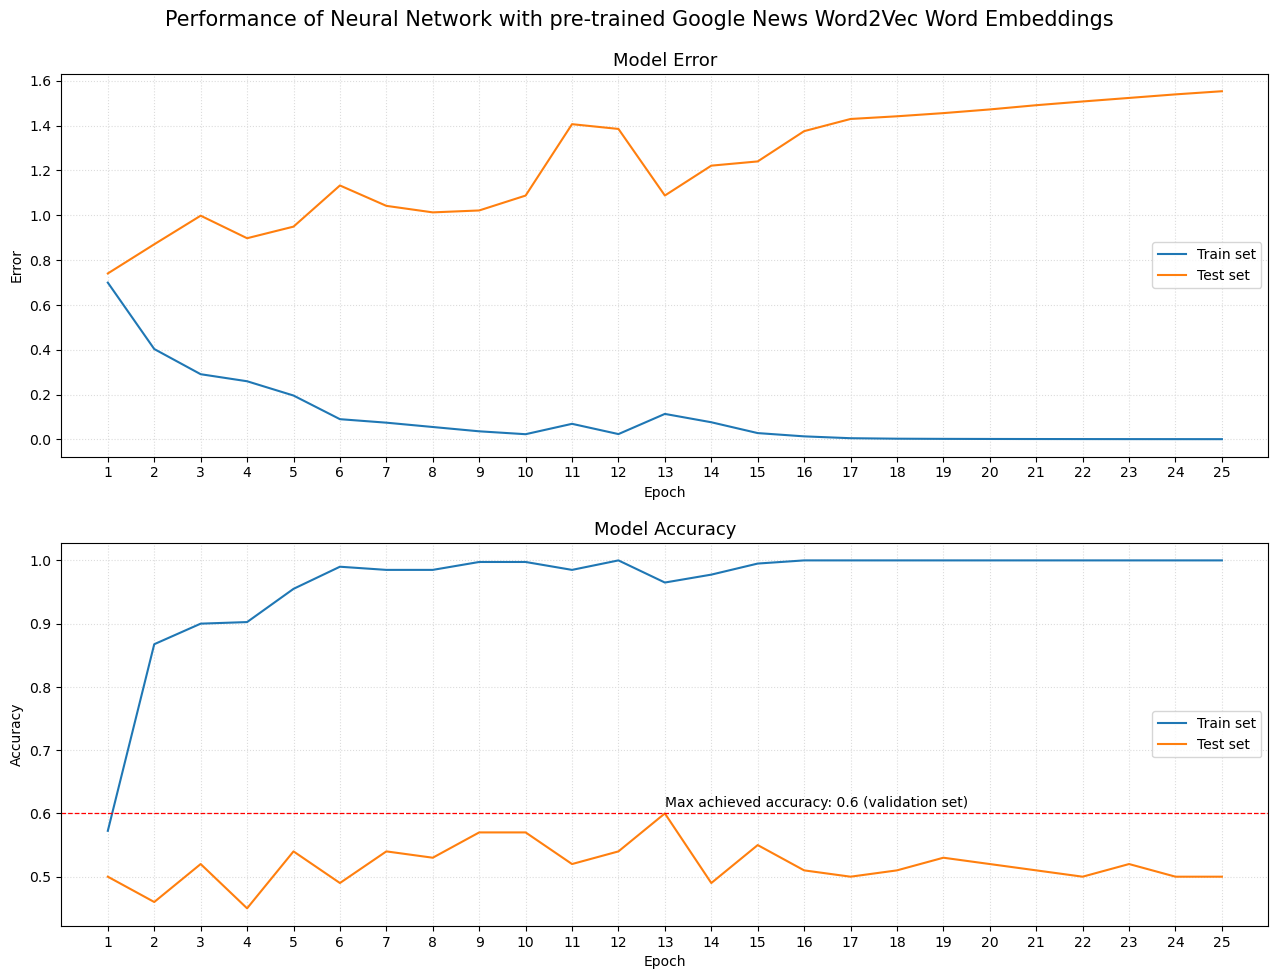

In [11]:
fig = plt.figure(figsize=(13,10))
loss = fig.add_subplot(2,1,1) 
accuracy = fig.add_subplot(2,1,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticks(range(0,25))
accuracy.set_xticklabels(range(1,26))
accuracy.set_xlim(-1,25)
accuracy.legend(['Train set', 'Test set'], loc='center right')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
accuracy.axhline(y=0.60, color='r', lw=0.9, ls='--')
accuracy.annotate('Max achieved accuracy: 0.6 (validation set)', xy=(12,0.61))

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticks(range(0,25))
loss.set_xticklabels(range(1,26))
loss.set_xlim(-1,25)
loss.legend(['Train set', 'Test set'], loc='center right')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Performance of Neural Network with pre-trained Google News Word2Vec Word Embeddings', fontsize=15)
plt.tight_layout(pad=1.5)
plt.show()

Using Google News Word2Vec Word Embeddings produced the worst model, in terms of out-of-sample accuracy: **60% accuracy with Google News Word2Vec vs 65% with our own word embeddings.**  
Again, it appears that the population the Word2Vec model was trained on is too different from our own population.

## End of Part 3